# Bayesian CUPED & Sensitivity Analysis

Motivated by the great blog post by [Understanding CUPED](https://towardsdatascience.com/understanding-cuped-a822523641af) by [Matteo Courthoud](https://medium.com/@matteo.courthoud), we explore a Bayesian approach to [CUPED](https://dl.acm.org/doi/abs/10.1145/2433396.2433413) to understand its sensitivity with respect to the covariance parameter $\theta$ of the pre-post mean model. I will assume that the reader is already familiar with CUPED and has read Matteo's blog post (highly recommended!). Here we focus on the sensitivity component. We do not do this in full generality but rather focus on the specific example of Matteo's blog post.

**Warning:** Please do not take this results too seriously. This is just a sensitivity analysis I simply felt like doing.


## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.handlers import do
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

rng = np.random.default_rng(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Generate Data

We use a synthetic dataset from Matteo's repository [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). We simulate a pre and post experiment `revenue` variable under the presence of an intervention `ad_campaign` in a randomized controlled trial.

In [2]:
def generate_data(rng, alpha=5, beta=0, gamma=3, delta=2, n=100, seed=1):
    np.random.seed(seed)

    # Individuals
    individual = range(1, n + 1)

    # Treatment status
    d = rng.binomial(1, 0.5, n)

    # Individual outcome pre-treatment
    y0 = alpha + beta * d + rng.normal(0, 1, n)
    y1 = y0 + gamma + delta * d + rng.normal(0, 1, n)

    # Generate the dataframe
    return pd.DataFrame(
        {"individual": individual, "ad_campaign": d, "revenue0": y0, "revenue1": y1}
    )


data_df: pd.DataFrame = generate_data(rng)

data_df.head()

,individual,ad_campaign,revenue0,revenue1
0,1,1,5.399774,10.394652
1,2,0,4.094521,6.931078
2,3,1,4.621837,9.959412
3,4,1,6.299228,12.706710
4,5,0,4.643736,7.734321


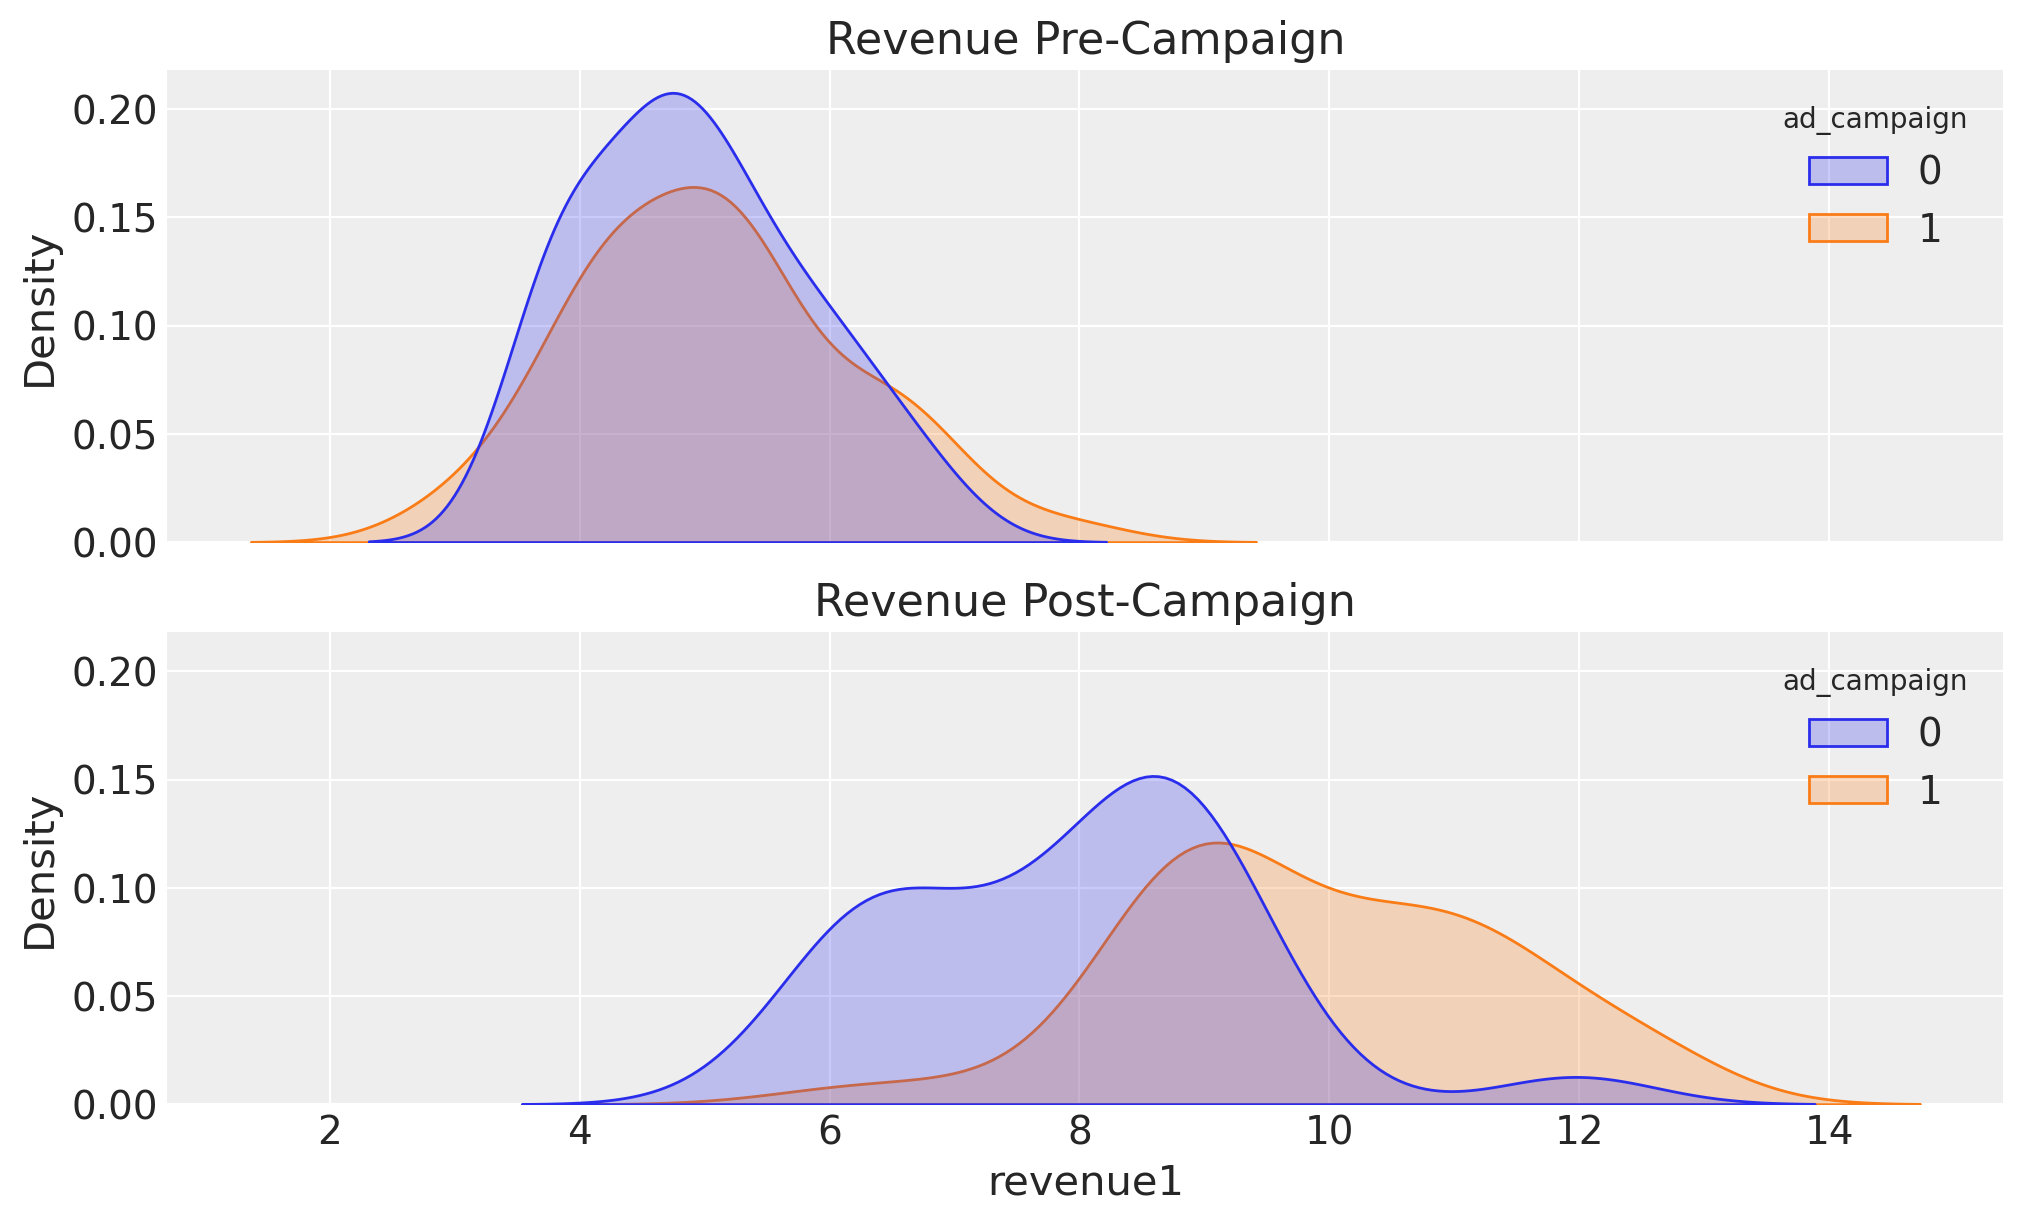

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, layout="constrained")

sns.kdeplot(data=data_df, x="revenue0", hue="ad_campaign", fill=True, ax=ax[0])
ax[0].set_title("Revenue Pre-Campaign")

sns.kdeplot(data=data_df, x="revenue1", hue="ad_campaign", fill=True, ax=ax[1])
ax[1].set_title("Revenue Post-Campaign");

## Effect Estimation: Difference in Means

We can compute the point estimate of the difference in means as follows:

In [4]:
difference_in_means = (
    data_df.query("ad_campaign == True")["revenue1"].mean()
    - data_df.query("ad_campaign == False")["revenue1"].mean()
)

print(f"Difference in means: {difference_in_means:.3f}")

Difference in means: 1.927


We are of course interested in quantifying the uncertainty of this estimate. We can do this using a simple linear regression model. We use a Bayesian approach with non-very informative priors, to be able to compare the results with the CUPED approach.

In [5]:
ad_campaign = data_df.ad_campaign.to_numpy()
revenue0 = data_df.revenue0.to_numpy()
revenue1 = data_df.revenue1.to_numpy()

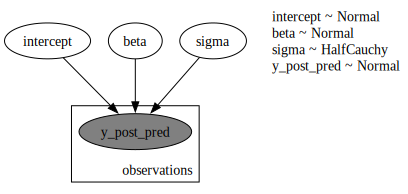

In [6]:
def difference_in_means_model(y_post, treatment) -> None:
    n_samples = len(treatment)
    intercept = numpyro.sample("intercept", dist.Normal(0, 2))
    beta = numpyro.sample("beta", dist.Normal(0, 3))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2))

    mu = intercept + beta * treatment

    with numpyro.plate("observations", n_samples):
        numpyro.sample("y_post_pred", dist.Normal(mu, sigma), obs=y_post)


numpyro.render_model(
    difference_in_means_model,
    model_args=(revenue1, ad_campaign),
    render_distributions=True,
    render_params=True,
)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

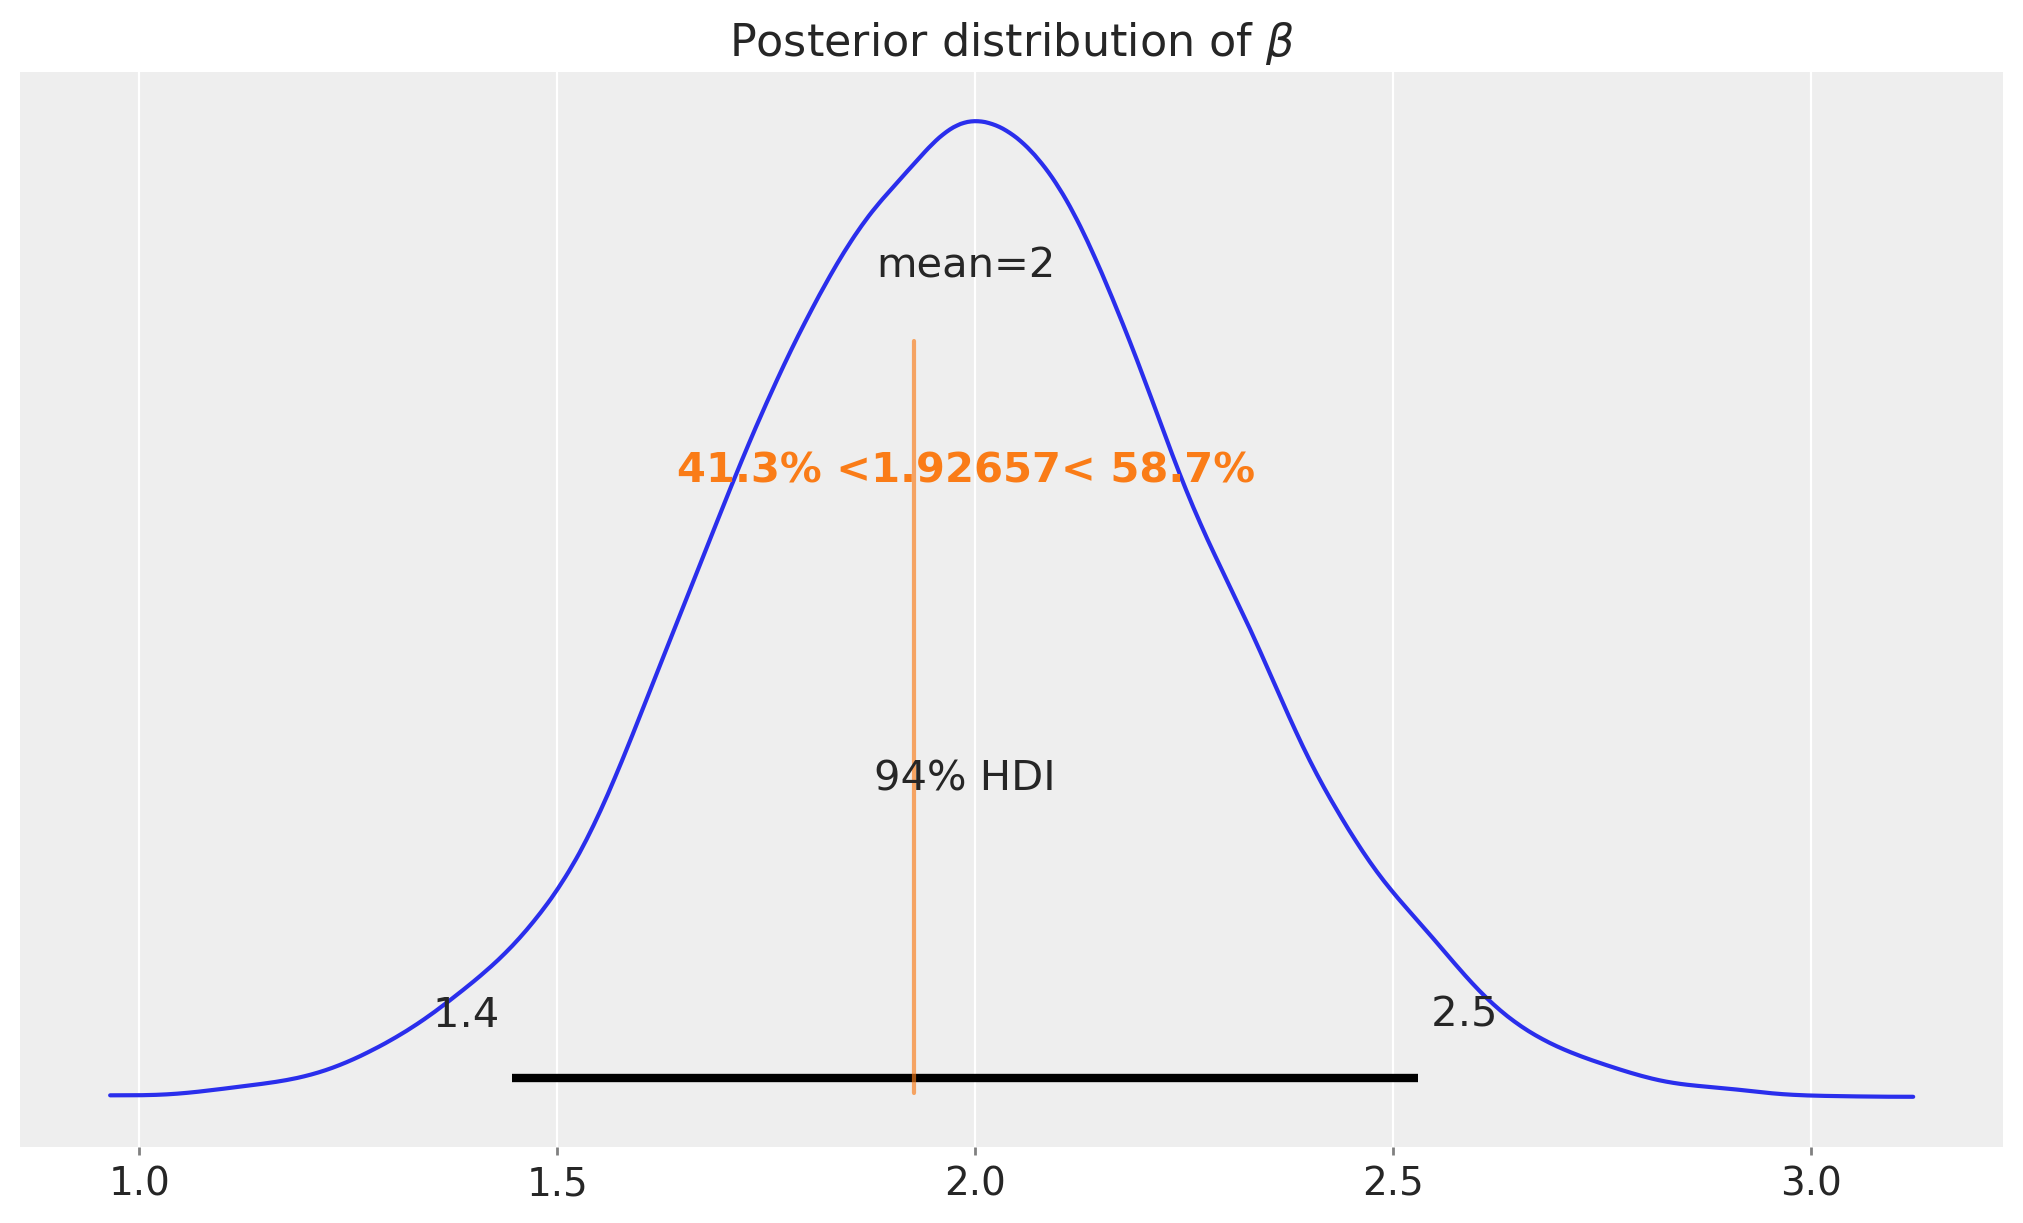

In [7]:
mcmc_difference_in_means = MCMC(
    sampler=NUTS(difference_in_means_model),
    num_warmup=1_500,
    num_samples=4_000,
    num_chains=4,
)

rng_key, rng_subkey = random.split(rng_key)
mcmc_difference_in_means.run(rng_subkey, revenue1, ad_campaign)

idata_difference_in_means = az.from_numpyro(mcmc_difference_in_means)

fig, ax = plt.subplots()
az.plot_posterior(
    idata_difference_in_means, var_names=["beta"], ref_val=difference_in_means, ax=ax
)
ax.set_title(r"Posterior distribution of $\beta$");

As expected, the posterior distribution of the difference in means is centered around the true value of $2$ (from the data generating process).

Let's compute the standard deviation of the posterior distribution:

In [8]:
print(f"std: {idata_difference_in_means['posterior']['beta'].std().item():.3f}")

std: 0.286


## Bayesian CUPED

We now turn to the Bayesian CUPED approach. Recall the algorithm for the CUPED estimator:

1. Regress $\text{revenue}_1$ on $\text{revenue}_0$ and estimate the $\theta$ coefficient.
2. Compute ${revenue}_{cuped} = \bar{\text{revenue}}_1 - \theta \times \bar{\text{revenue}}_0$.
3. Compute the difference of $\widehat{\text{revenue}}_{cuped}$ between treatment and control group.


**The motivation of this simulation is:** How does the uncertainty on $\theta$ impact the uncertainty of the CUPED estimate?

To answer this question, we implement these steps in a single Bayesian model (with same non-informative priors as before).

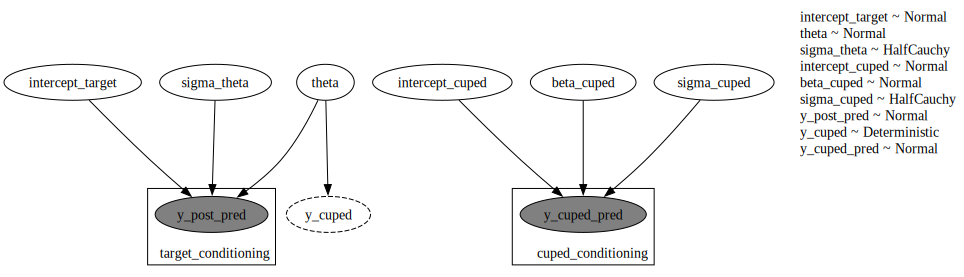

In [9]:
def cuped_model(y_post, treatment, y_pre) -> None:
    n_samples = len(ad_campaign)

    intercept_target = numpyro.sample("intercept_target", dist.Normal(0, 2))
    theta = numpyro.sample("theta", dist.Normal(0, 3))
    sigma_theta = numpyro.sample("sigma_theta", dist.HalfCauchy(2))

    intercept_cuped = numpyro.sample("intercept_cuped", dist.Normal(0, 2))
    beta_cuped = numpyro.sample("beta_cuped", dist.Normal(0, 3))
    sigma_cuped = numpyro.sample("sigma_cuped", dist.HalfCauchy(2))

    mu_target = intercept_target + theta * y_pre

    with numpyro.plate("target_conditioning", n_samples):
        numpyro.sample("y_post_pred", dist.Normal(mu_target, sigma_theta), obs=y_post)

    y_cuped = numpyro.deterministic(
        "y_cuped", y_post - theta * (y_pre - jnp.mean(y_pre))
    )

    with numpyro.plate("cuped_conditioning", n_samples):
        numpyro.sample(
            "y_cuped_pred",
            dist.Normal(intercept_cuped + beta_cuped * treatment, sigma_cuped),
            obs=y_cuped,
        )


numpyro.render_model(
    cuped_model,
    model_args=(revenue1, ad_campaign, revenue0),
    render_distributions=True,
    render_params=True,
)

In [10]:
mcmc_cuped = MCMC(
    sampler=NUTS(cuped_model),
    num_warmup=1_500,
    num_samples=4_000,
    num_chains=4,
)
rng_key, rng_subkey = random.split(rng_key)
mcmc_cuped.run(rng_subkey, revenue1, ad_campaign, revenue0)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

First, let's look into the posterior distribution of $\theta$:

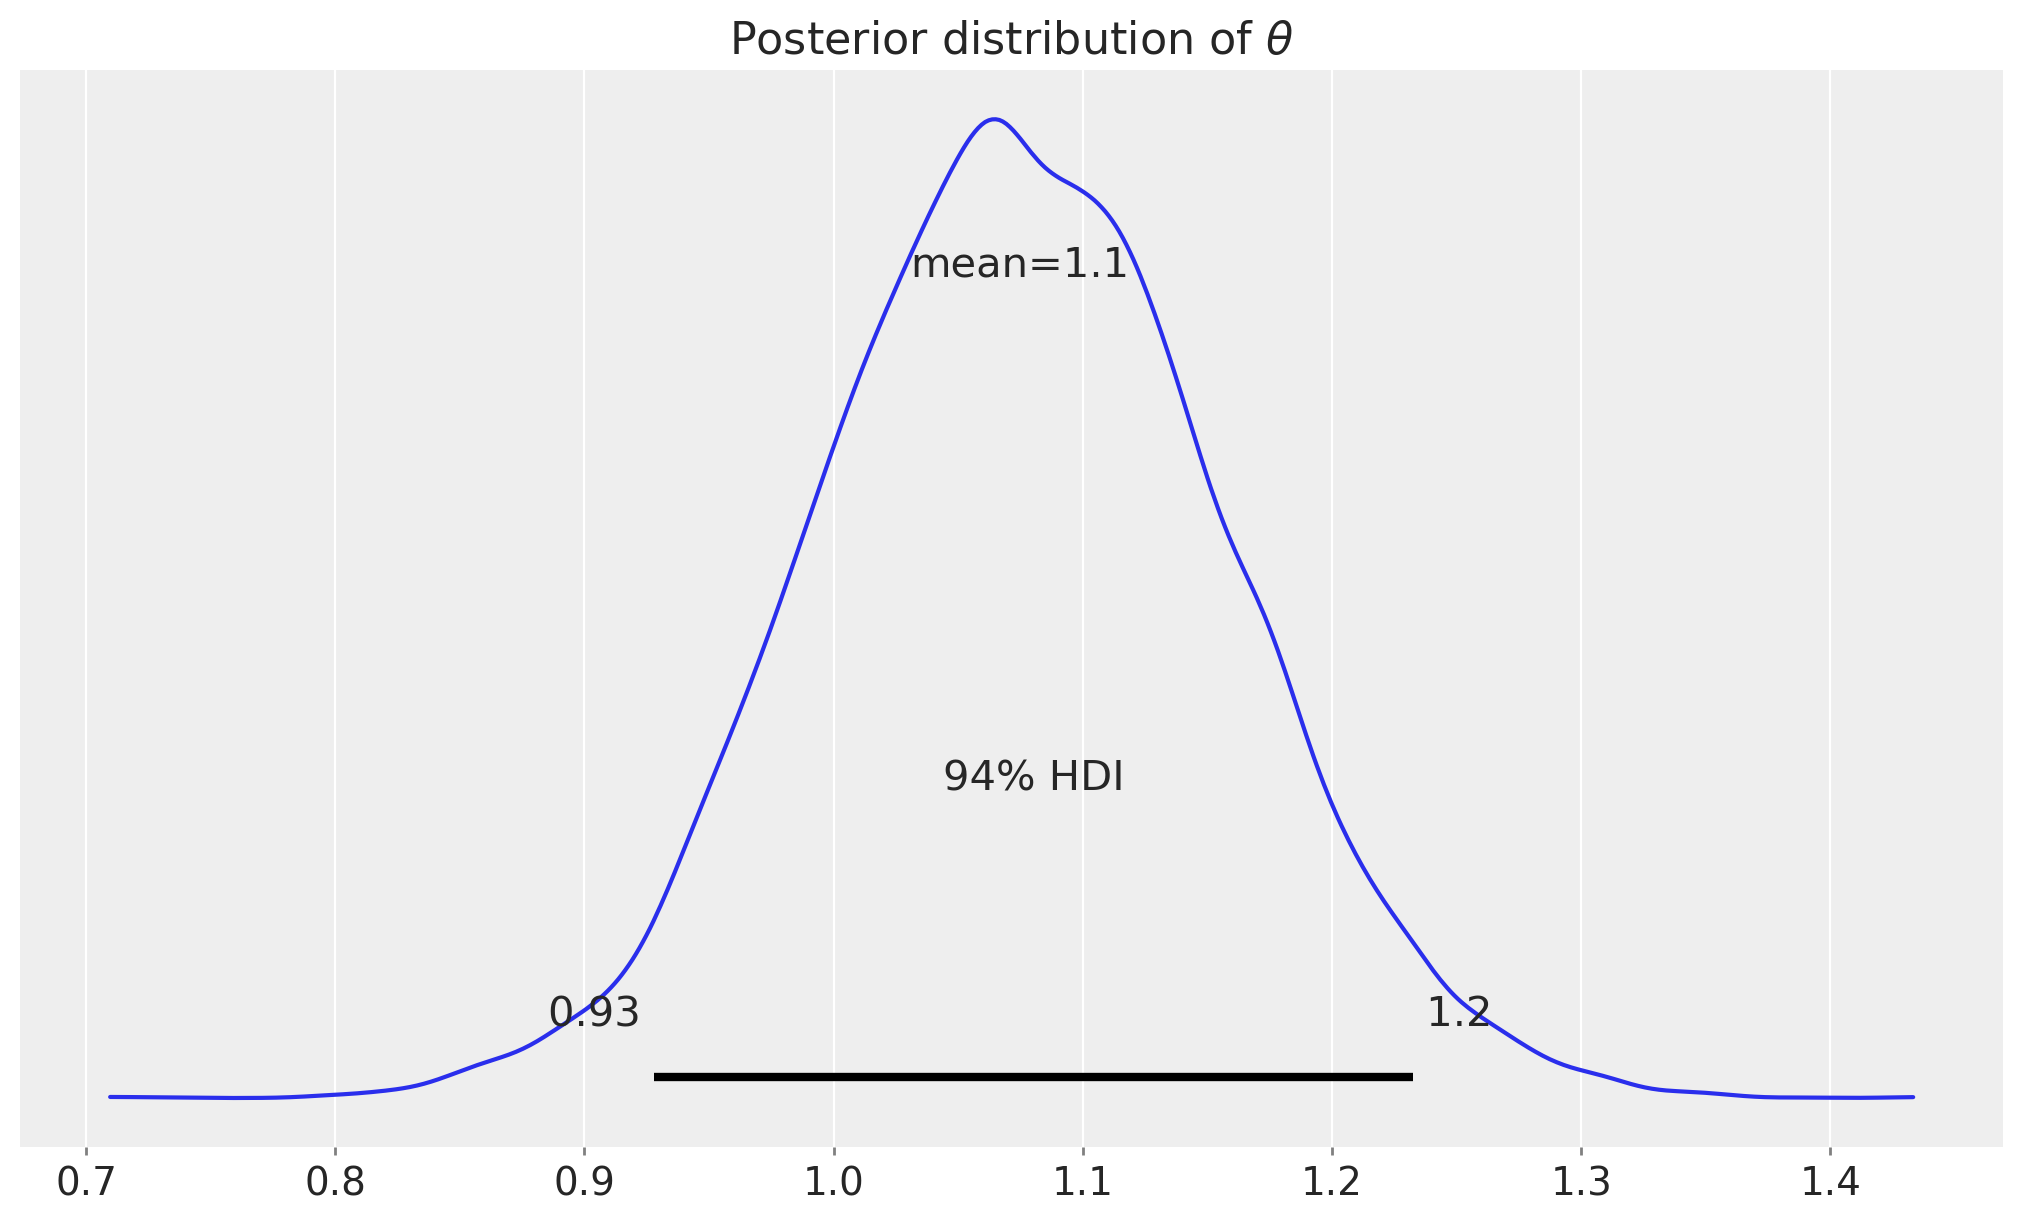

In [11]:
idata_cuped = az.from_numpyro(mcmc_cuped)
fig, ax = plt.subplots()
az.plot_posterior(idata_cuped, var_names=["theta"], ax=ax)
ax.set_title(r"Posterior distribution of $\theta$");

The point estimate of $\theta$ is centered around the true value of $1.1$. 

Next we look into the posterior distribution of the CUPED effect estimate:

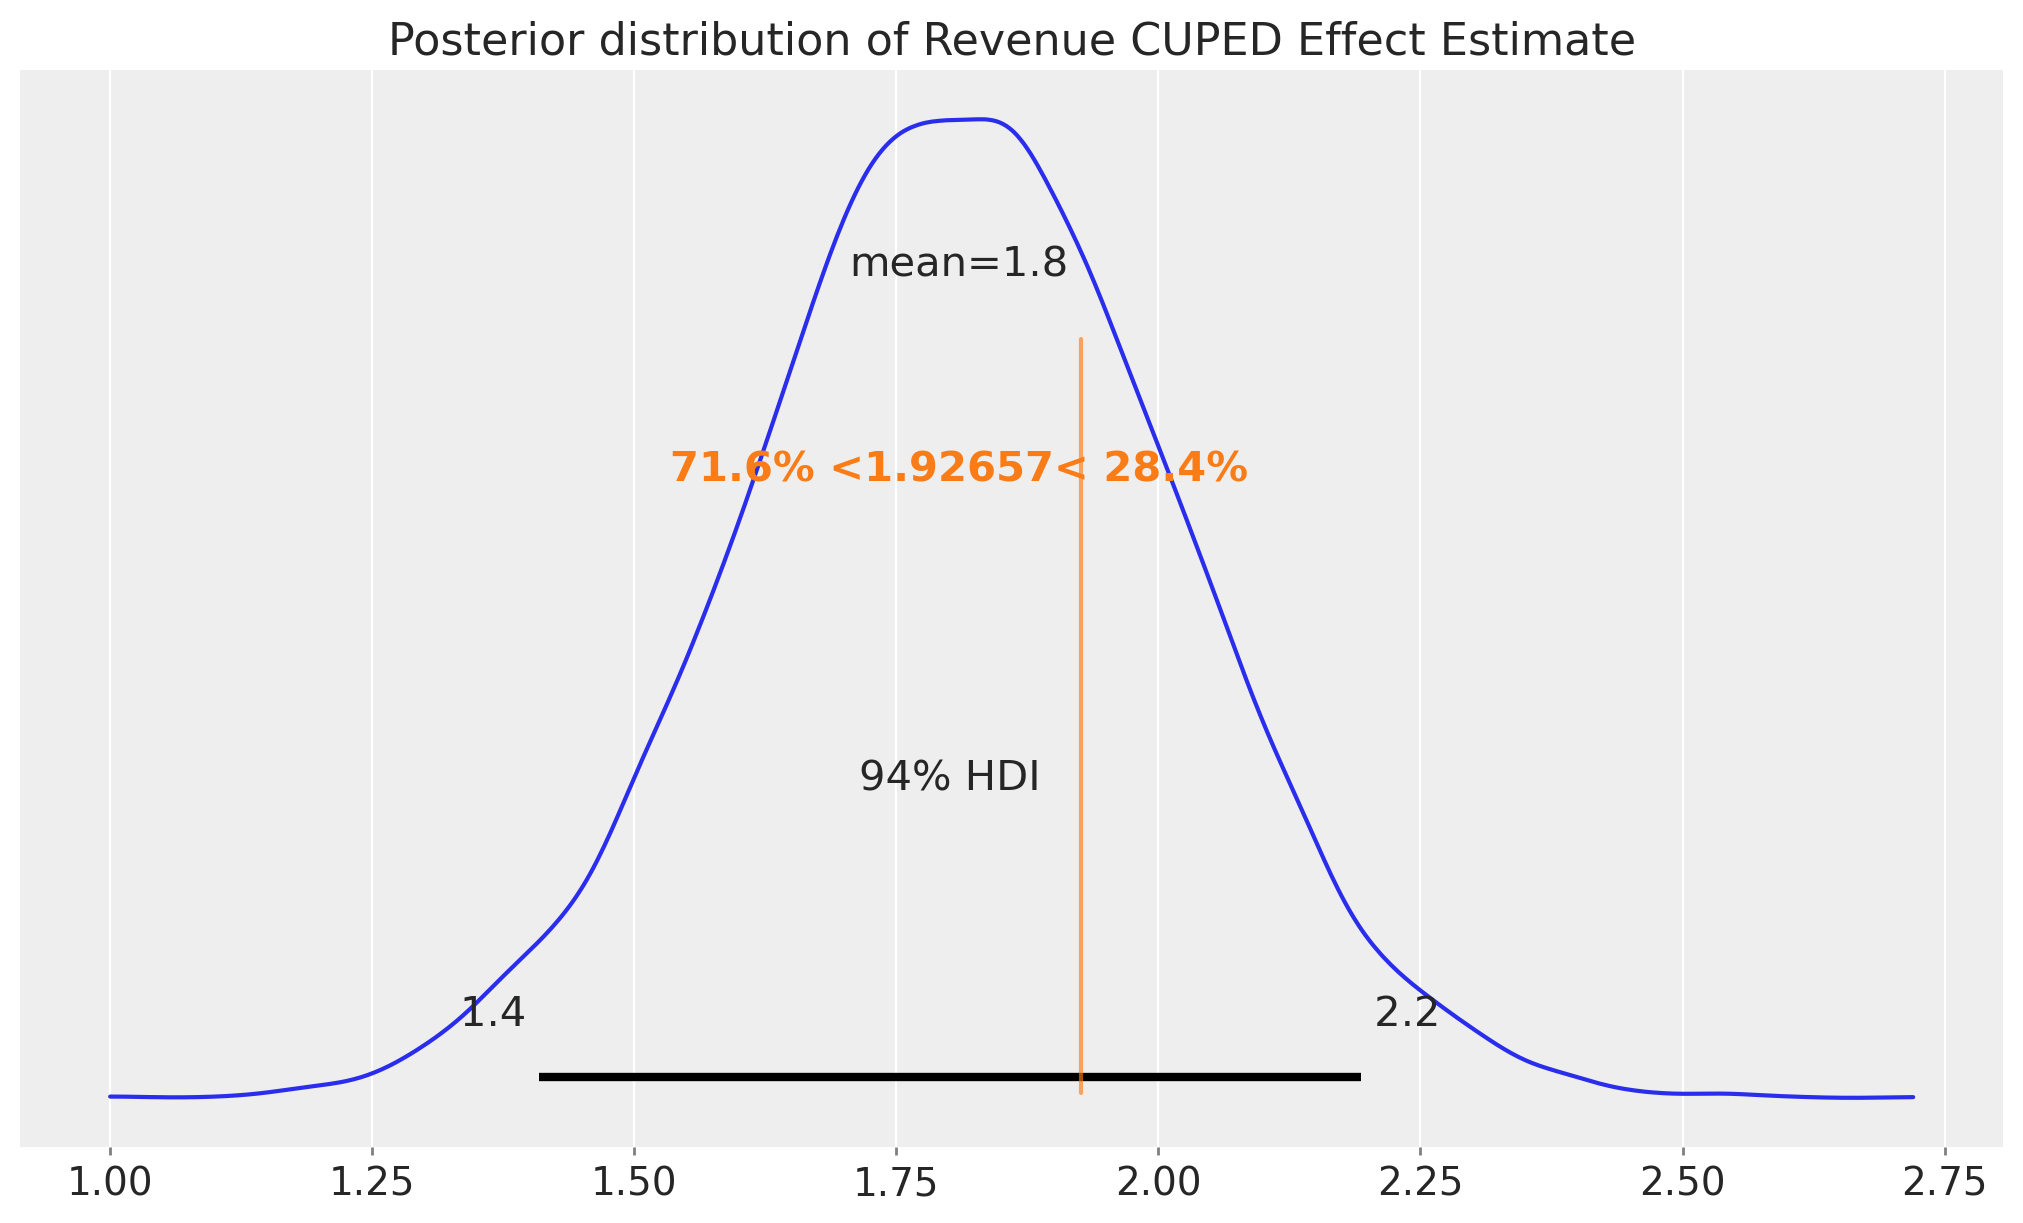

In [12]:
fig, ax = plt.subplots()
az.plot_posterior(
    idata_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax
)
ax.set_title("Posterior distribution of Revenue CUPED Effect Estimate");

In [13]:
print(f"std: {idata_cuped['posterior']['beta_cuped'].std().item():.3f}")

std: 0.207


As expected, the posterior distribution of the CUPED effect estimate is narrower than the one of the simple difference in means. So far so good! The result's match Matteo's blog post.

For the sake of completeness, let's compare the posterior distributions of the difference in means and the CUPED effect estimate:

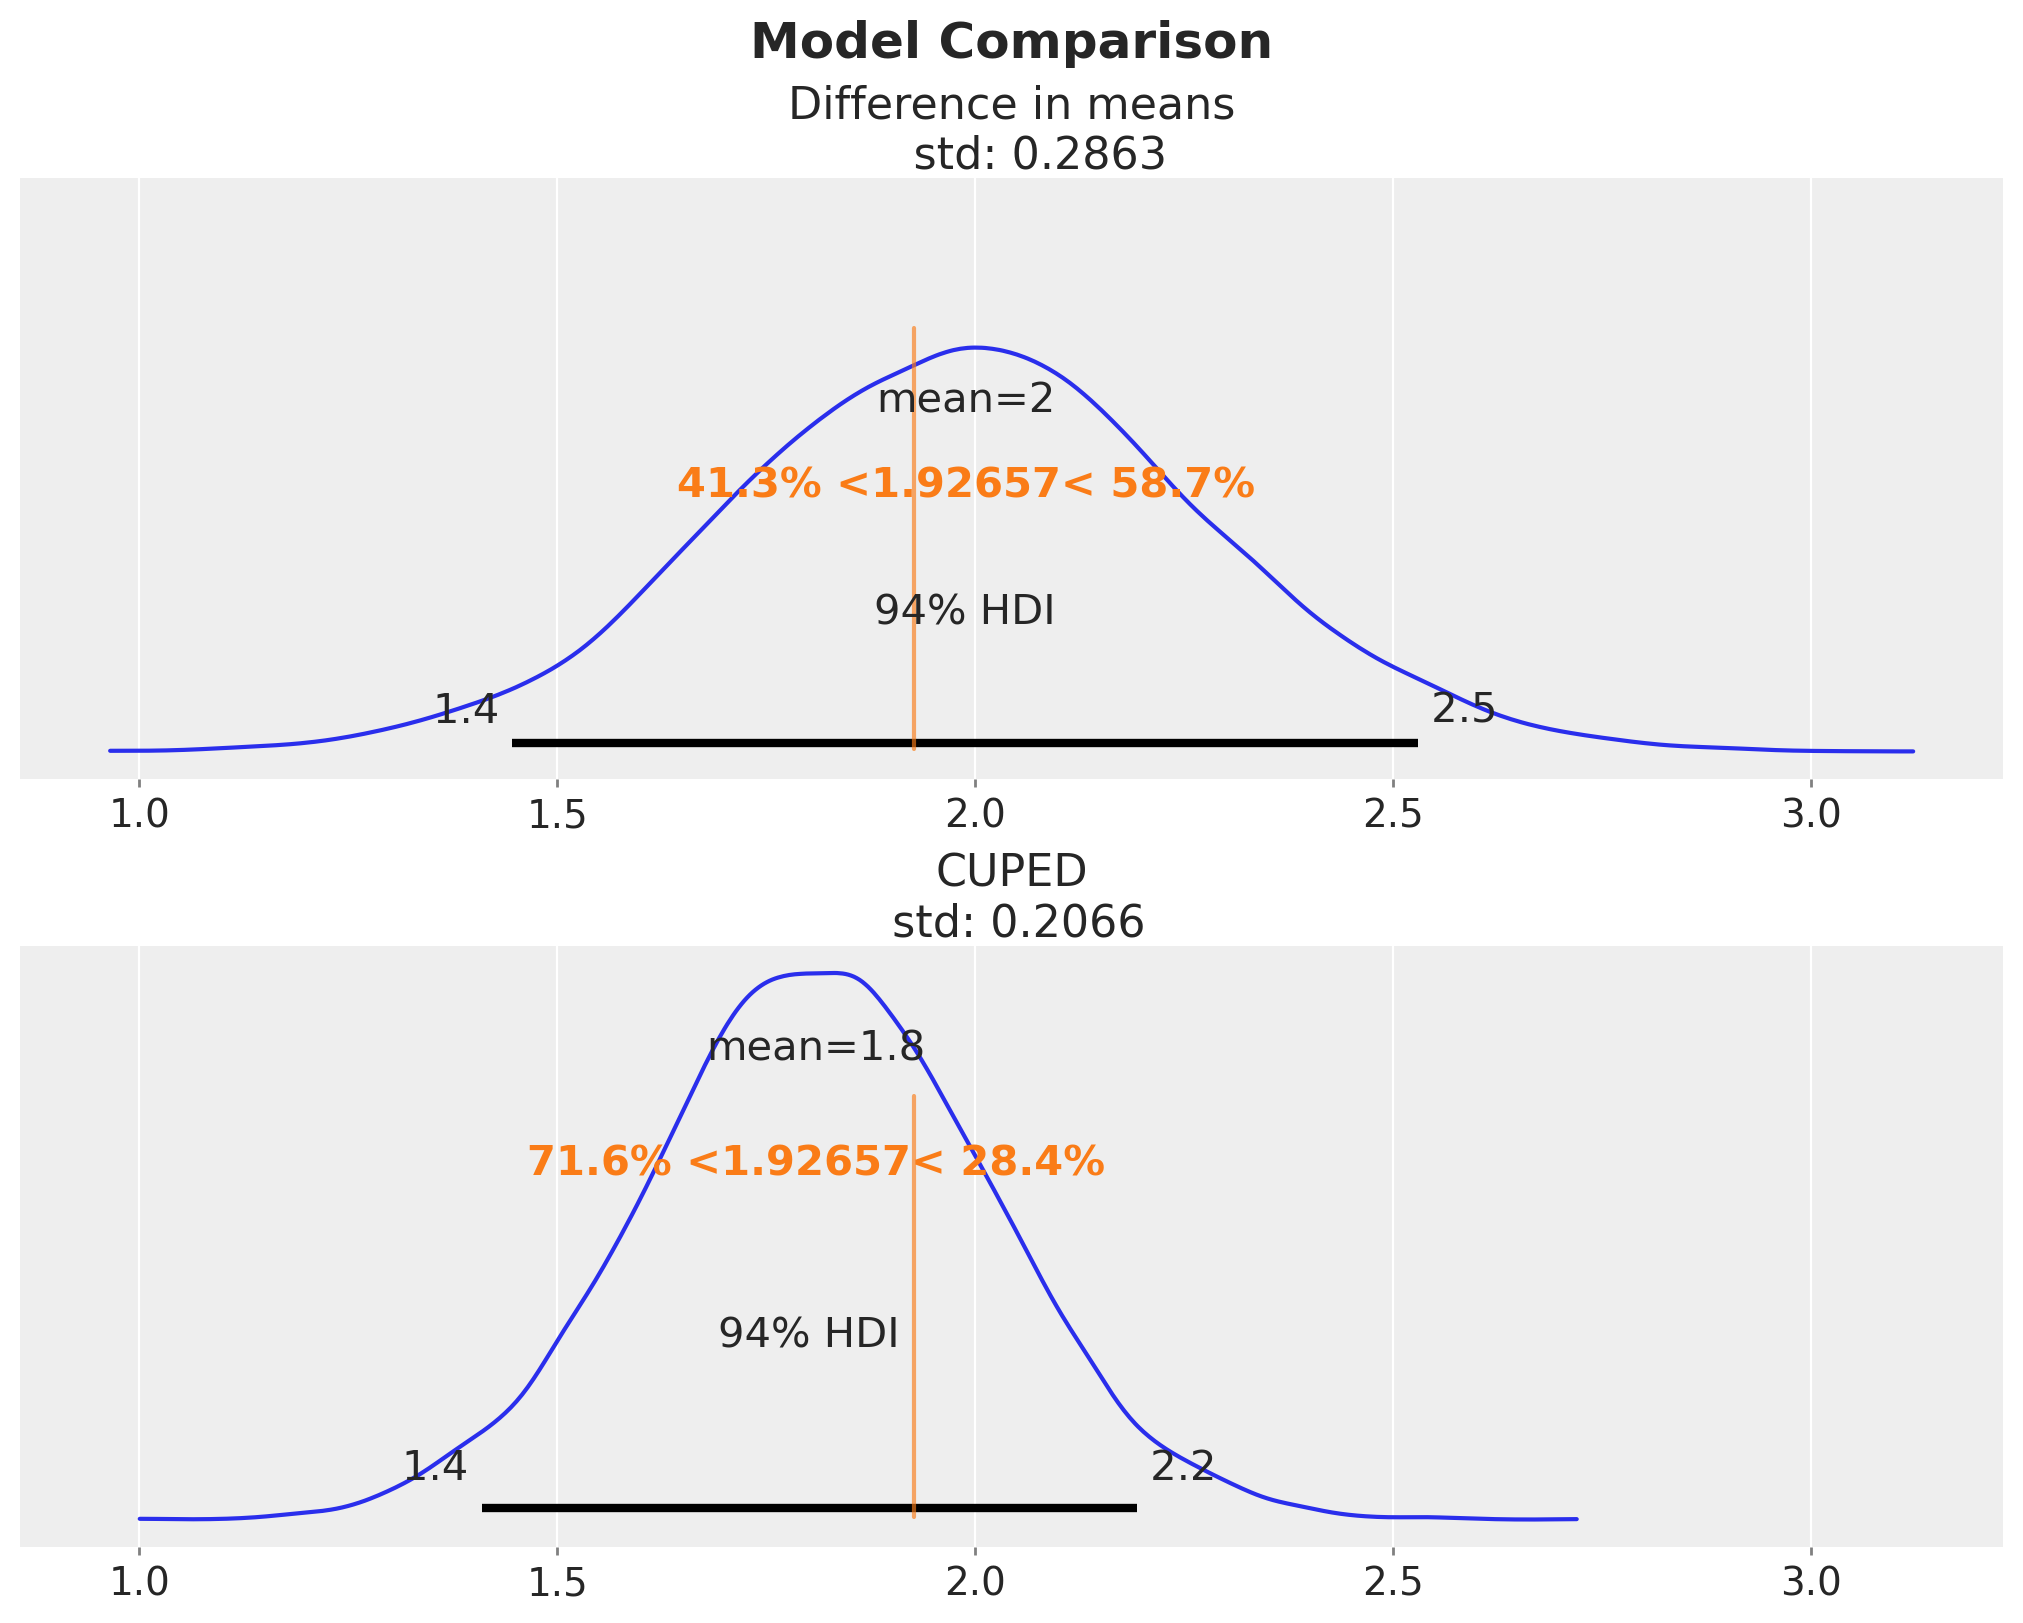

In [14]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=True,
    sharey=True,
    layout="constrained",
)

az.plot_posterior(
    idata_difference_in_means, var_names=["beta"], ref_val=difference_in_means, ax=ax[0]
)
ax[0].set_title(
    f"""Difference in means
    std: {idata_difference_in_means['posterior']['beta'].std().item():.4f}"""
)

az.plot_posterior(
    idata_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax[1]
)
ax[1].set_title(
    f"CUPED\n std: {idata_cuped['posterior']['beta_cuped'].std().item():.4f}"
)

fig.suptitle("Model Comparison", fontsize=18, fontweight="bold");

Here we have a clear visual evidence of the variance reduction of the CUPED model.

## Graph Surgery

We now turn to the sensitivity analysis. We want to see how the uncertainty of the CUPED estimate evolves with respect to the uncertainty of the $\theta$ coefficient.

To do this, we use the [`do`](https://num.pyro.ai/en/stable/handlers.html#do) operator to set the value of $\theta$ to the mean of its posterior distribution. This way we can mimic what we would have done in a traditional two-step approach.


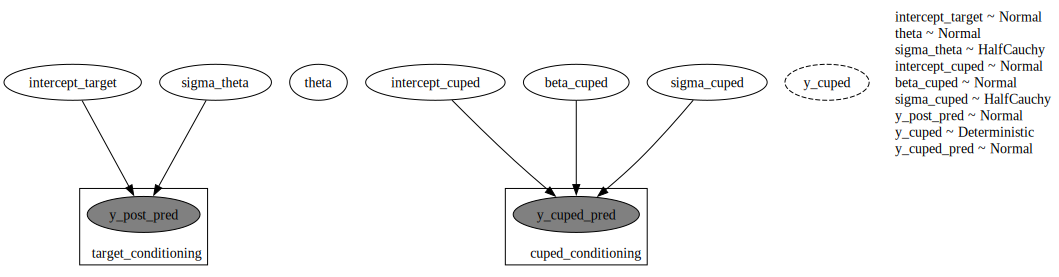

In [15]:
do_cuped_model = do(
    cuped_model, data={"theta": idata_cuped["posterior"]["theta"].mean().item()}
)

numpyro.render_model(
    do_cuped_model,
    model_args=(revenue1, ad_campaign, revenue0),
    render_distributions=True,
    render_params=True,
)

Notice that we have removed the relationship between $\theta$ and the `revenue1 ~ revenue0` model.


Next, we fit the later model of the CUPED algorithm:

In [16]:
mcmc_do_cuped = MCMC(
    sampler=NUTS(do_cuped_model),
    num_warmup=1_500,
    num_samples=4_000,
    num_chains=4,
)
rng_key, rng_subkey = random.split(rng_key)
mcmc_do_cuped.run(rng_subkey, revenue1, ad_campaign, revenue0)

idata_do_cuped = az.from_numpyro(mcmc_do_cuped)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

## Comparison

Finally, we compare all the effect estimation of the three models. In particular, we focus on the standard deviation of the posterior distributions.

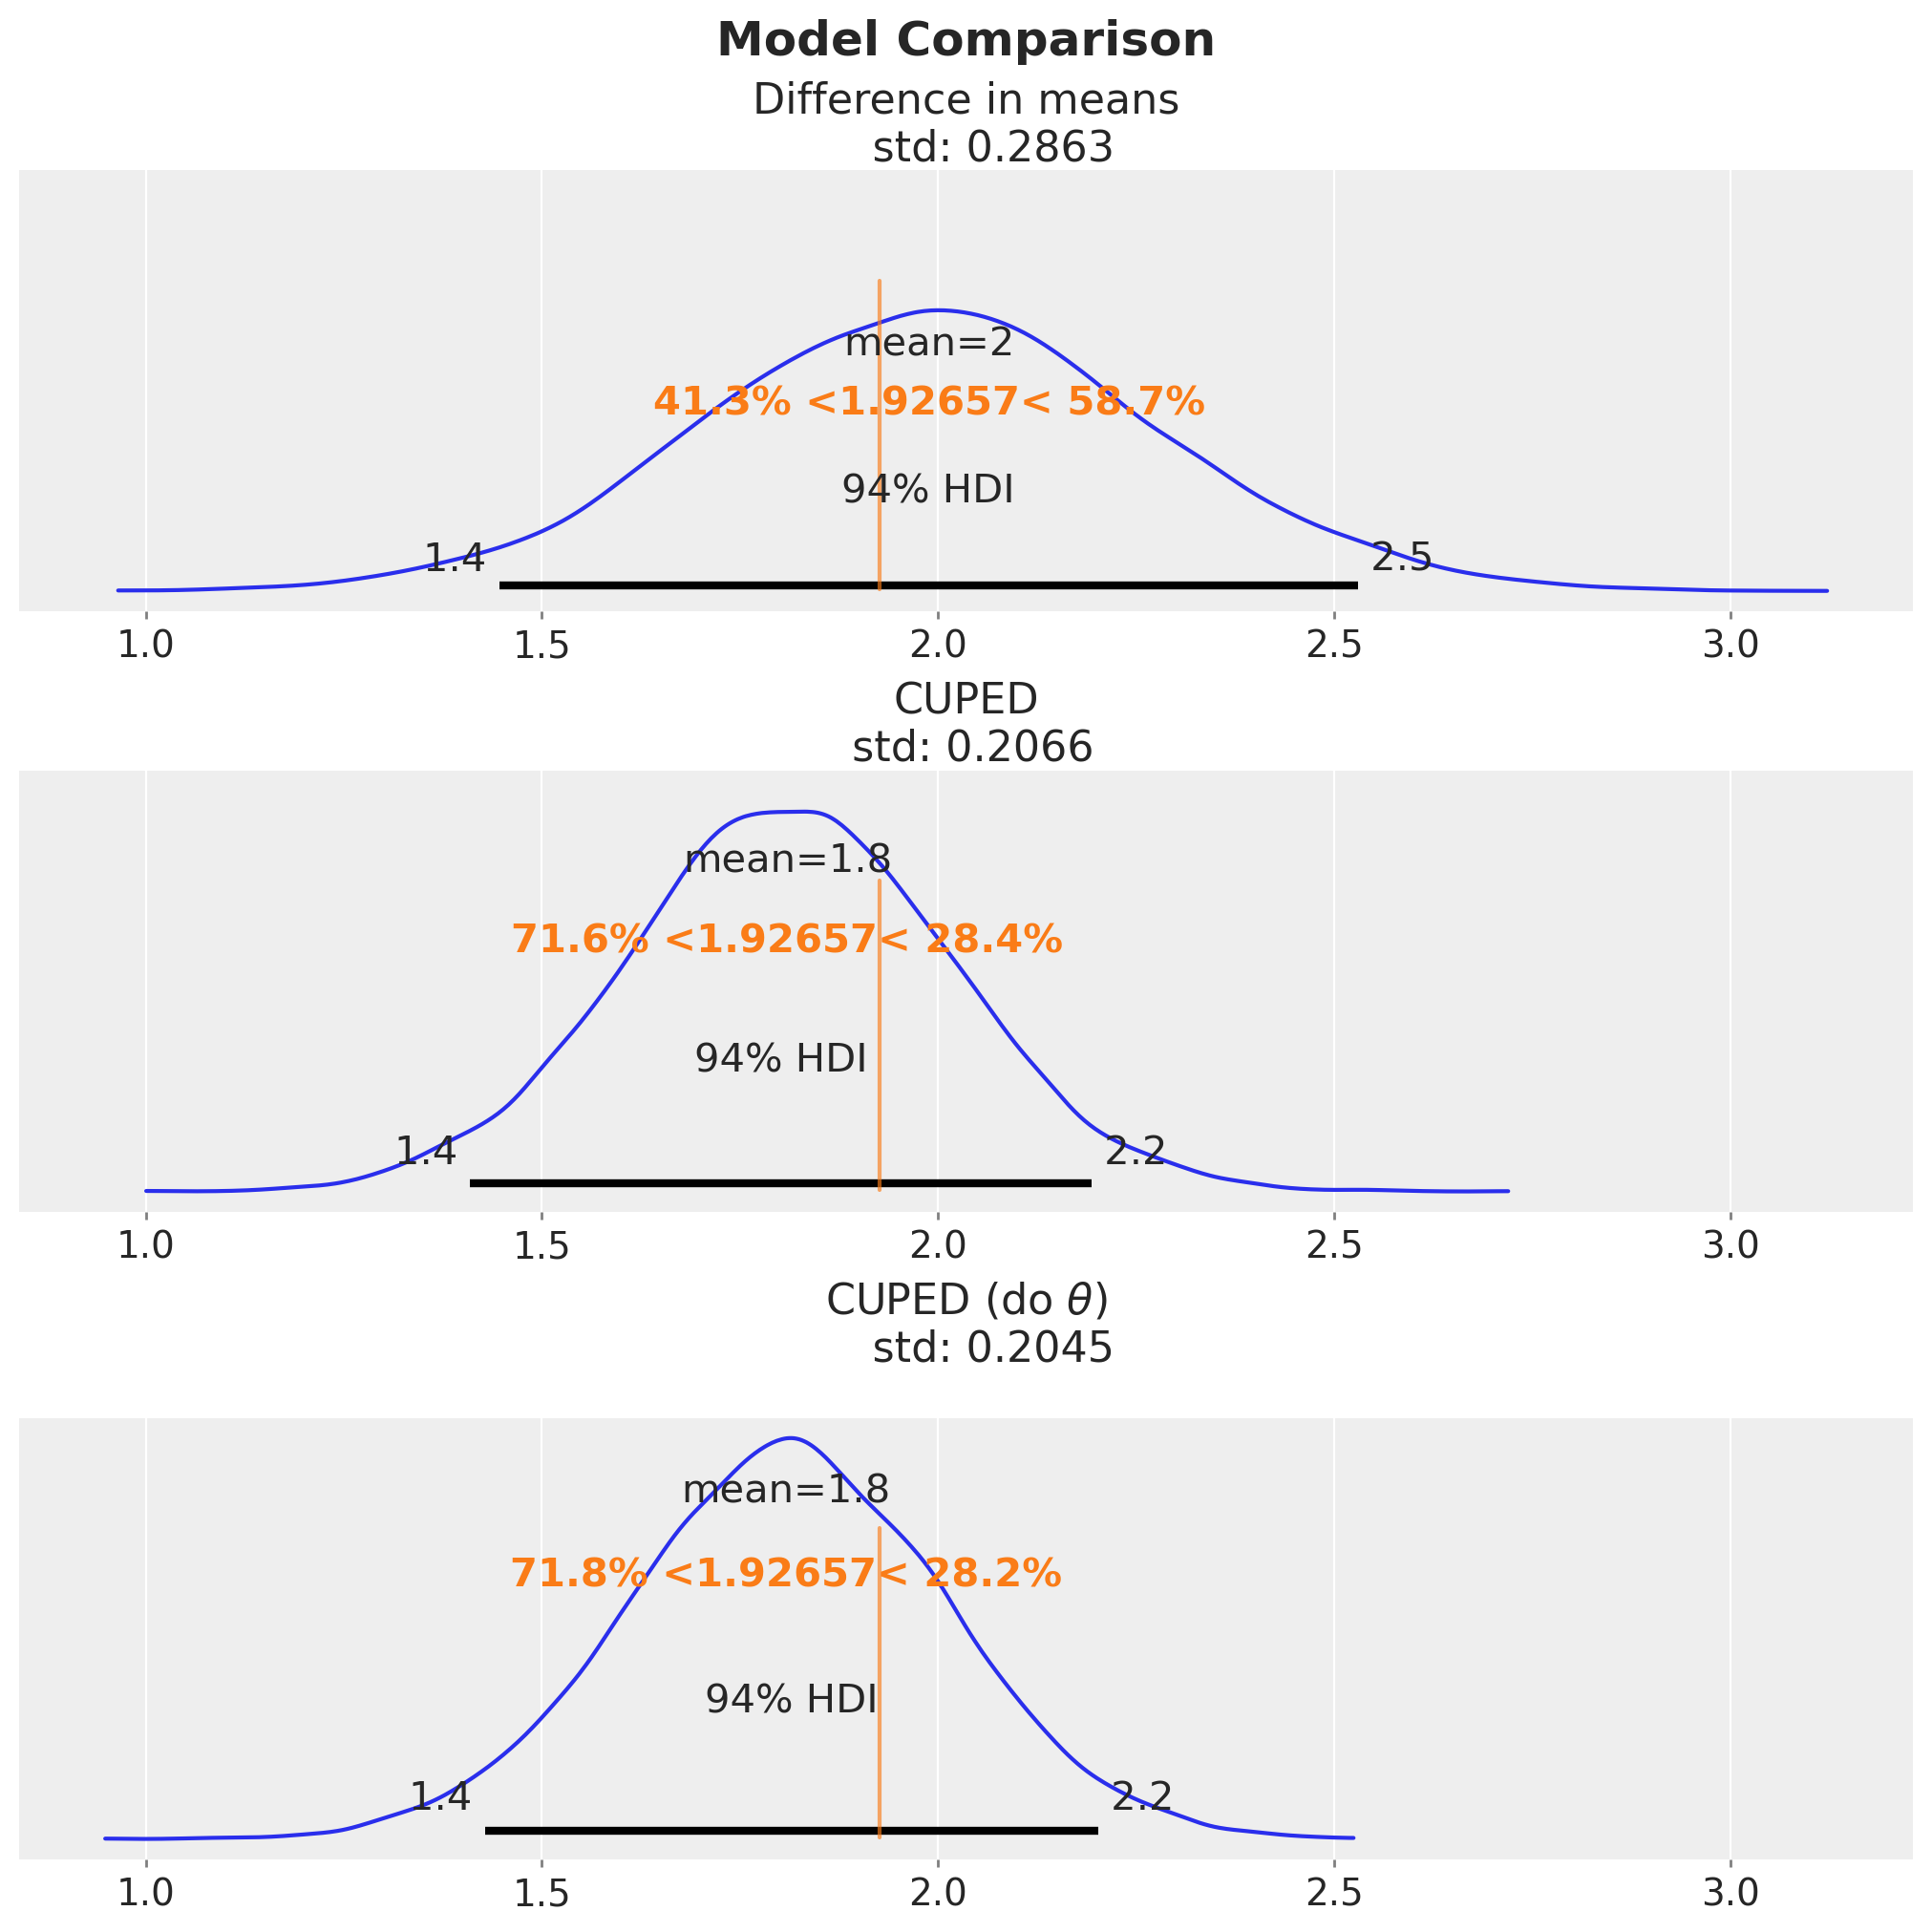

In [17]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

az.plot_posterior(
    idata_difference_in_means, var_names=["beta"], ref_val=difference_in_means, ax=ax[0]
)
ax[0].set_title(
    f"""Difference in means
    std: {idata_difference_in_means['posterior']['beta'].std().item():.4f}"""
)

az.plot_posterior(
    idata_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax[1]
)
ax[1].set_title(
    f"CUPED\n std: {idata_cuped['posterior']['beta_cuped'].std().item():.4f}"
)

az.plot_posterior(
    idata_do_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax[2]
)
ax[2].set_title(
    f"""CUPED (do $\\theta$)
    std: {idata_do_cuped['posterior']['beta_cuped'].std().item():.4f}
    """
)

fig.suptitle("Model Comparison", fontsize=18, fontweight="bold");

We see that the estimate and uncertainty of the full Bayesian CUPED model is very similar (almost identical) to the one of the CUPED model after graph surgery. The latter standard deviation is just slightly smaller (approximately $1\%$) than the one of the full Bayesian CUPED model.

I wonder if this effect could be made more pronounced with a weaker relationship between $\text{revenue}_1$ and $\text{revenue}_0$. If you have any input on this, please let me know!